In [3]:
import os
import pandas as pd

def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [4]:
folder_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

In [5]:
!pip install langid

     ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
      --------------------------------------- 0.0/1.9 MB 325.1 kB/s eta 0:00:06
     - -------------------------------------- 0.1/1.9 MB 544.7 kB/s eta 0:00:04
     --- ------------------------------------ 0.2/1.9 MB 1.1 MB/s eta 0:00:02
     ------- -------------------------------- 0.4/1.9 MB 1.8 MB/s eta 0:00:01
     ----------- ---------------------------- 0.6/1.9 MB 2.5 MB/s eta 0:00:01
     ----------------------- ---------------- 1.1/1.9 MB 4.0 MB/s eta 0:00:01
     ------------------------- -------------- 1.2/1.9 MB 3.5 MB/s eta 0:00:01
     -------------------------------------- - 1.8/1.9 MB 4.9 MB/s eta 0:00:01
     ---------------------------------------- 1.9/1.9 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for langid: filename=langid-1.1.6-

In [6]:
from langid.langid import LanguageIdentifier, model

def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row["sentence"])
        if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

In [7]:
train_df_vi, train_df_other = identify_vn(train_df)

In [8]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [9]:
train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

C:\Users\quang\AppData\Local\Temp\ipykernel_25608\1058621333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]


In [10]:
train_df_vi

,sentence,label,preprocess_sentence
0,Mua có mỗi Bingsu thập_cẩm 45k mà mình f đợi h...,0,mua có mỗi bingsu thập cẩm k mà mình f đợi hơn...
1,Thứ 6 nào ta cùng quẩy 💣 💣 💣\n Vuvuzela beer c...,0,thứ nào ta cùng quẩy vuvuzela beer club chung ...
2,"Mình đi với nhóm , tổng_cộng 4 người ăn chỉ có...",0,mình đi với nhóm tổng cộng người ăn chỉ có khô...
3,"nhân_viên phục_vụ không mấy tận_tình , đồ_ăn r...",0,nhân viên phục vụ không mấy tận tình đồ ăn ra ...
4,"Vào đây thì hết bàn , nhưng mình vẫn ngồi đợi ...",0,vào đây thì hết bàn nhưng mình vẫn ngồi đợi bì...
...,...,...,...
29995,2-9 mình đi với nhóm bạn tổng_cộng là 8ng.Thiệ...,1,mình đi với nhóm bạn tổng cộng là ng thiệt hại...
29996,sushi bình_dân mà chất_lượng không bình_dân ch...,1,sushi bình dân mà chất lượng không bình dân ch...
29997,Trời_ơi từ bé đến lớn chưa thử món kem nào bằn...,1,trời ơi từ bé đến lớn chưa thử món kem nào bằn...
29998,Nge mn cũng ns ngon nên hni đến coi thế_nào .\...,1,nge mn cũng ns ngon nên hni đến coi thế nào qu...


In [11]:
!pip install torchtext==0.16.0

   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.9 MB 1.6 MB/s eta 0:00:02
   --- ------------------------------------ 0.2/1.9 MB 2.2 MB/s eta 0:00:01
   --------- ------------------------------ 0.5/1.9 MB 3.6 MB/s eta 0:00:01
   --------------- ------------------------ 0.7/1.9 MB 4.3 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.9 MB 5.1 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.9 MB 5.1 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.9 MB 5.1 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.9 MB 5.1 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.9 MB 5.1 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.9 MB 5.1 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.9 MB 5.1 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.9 MB 5.1 MB/s eta 0:00:01
   ----------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1+cu121, but you have torch 2.1.0 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1+cu121, but you have torch 2.1.0 which is incompatible.


In [12]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [13]:
# word-based tokenizer
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [14]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [15]:
vocabulary["<pad>"]

0

In [16]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

In [17]:
import torch
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    encoded_sentences, labels = [], []
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)

    labels = torch.tensor(labels, dtype=torch.int64)
    encoded_sentences = pad_sequence(
        encoded_sentences,
        padding_value=vocabulary["<pad>"]
    )

    return encoded_sentences, labels

In [18]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [19]:
next(iter(train_dataloader))

(tensor([[ 642,   49, 1943,  ...,    6,    7,    6],
         [  93,   44,  128,  ...,   60, 7524,   60],
         [  22,   54, 1943,  ...,   94,   55,  392],
         ...,
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0],
         [   0,    0,    0,  ...,    0,    0,    0]]),
 tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
         1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
         0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
         0, 1, 0, 1, 1, 1, 1, 1]))

In [20]:
encoded_sentences, labels = next(iter(train_dataloader))

In [21]:
encoded_sentences.shape

torch.Size([397, 128])

In [22]:
import torch.nn as nn
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size, embedding_dim, kernel_sizes, num_filters, num_classes):
        super(TextCNN, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_classes = num_classes
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=k,
                stride=1
            ) for k in kernel_sizes])
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x.T).transpose(1, 2)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(x)
        return x

In [23]:
vocab_size = len(vocabulary)
embedding_dim = 100

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)

In [24]:
vocab_size

10000

In [28]:
import torch.nn.functional as F

In [29]:
predictions = model(encoded_sentences)
predictions

tensor([[ 7.6261e-02,  3.4285e-01],
        [-4.8114e-02,  4.7321e-01],
        [ 1.8367e-02,  5.4997e-01],
        [ 9.8496e-02,  7.6662e-01],
        [-3.5907e-02,  3.5039e-01],
        [-2.6606e-01,  6.5317e-01],
        [ 2.5402e-01,  6.6926e-01],
        [-1.1006e-01,  6.2264e-01],
        [-1.9884e-01,  7.8430e-01],
        [-4.8992e-01,  4.8387e-01],
        [-2.9772e-01,  5.7605e-01],
        [-1.4935e-01,  7.7364e-01],
        [-1.6272e-01,  4.5240e-01],
        [ 9.6198e-02,  8.5446e-01],
        [-1.4466e-01,  6.8220e-01],
        [-2.1434e-01,  4.4403e-01],
        [-1.3325e-02,  7.0259e-01],
        [-8.9358e-02,  8.9063e-01],
        [-1.1354e-01,  6.6352e-01],
        [ 3.2372e-02,  5.8143e-01],
        [-3.2832e-02,  5.2044e-01],
        [-4.5455e-01,  2.1247e-01],
        [-1.2695e-01,  3.4643e-01],
        [-8.5346e-02,  2.3788e-01],
        [-1.7323e-01,  6.9515e-01],
        [-1.6630e-01,  4.8922e-01],
        [-5.0060e-02,  6.6724e-01],
        [-2.8236e-01,  6.546

In [30]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

c:\Users\quang\anaconda3\envs\aie\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
loss = criterion(predictions, labels)
loss

tensor(0.7955, grad_fn=<NllLossBackward0>)

In [32]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero grad
        optimizer.zero_grad()

        # predictions
        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [33]:
model.to(device)

TextCNN(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [34]:
epoch_acc, epoch_loss = train(model, optimizer, criterion, train_dataloader, device)

| epoch   0 |    50/  233 batches | accuracy    0.767
| epoch   0 |   100/  233 batches | accuracy    0.839
| epoch   0 |   150/  233 batches | accuracy    0.862
| epoch   0 |   200/  233 batches | accuracy    0.873


In [35]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # predictions
            predictions = model(inputs)

            # compute loss
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [36]:
eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)

In [37]:
eval_acc, eval_loss

(0.8477, 0.3404486520758158)

In [38]:
import torch.nn.functional as F

In [40]:
num_class = 2
vocab_size = len(vocabulary)
embedding_dim = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextCNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    kernel_sizes=[3, 4, 5],
    num_filters=100,
    num_classes=2
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

learning_rate = 2e-4
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

num_epochs = 1
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        print('Save model at ./model/text_cnn_model.pt')
        torch.save(model.state_dict(), save_model + '/text_cnn_model.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + '/text_cnn_model.pt'))
    model.eval()

| epoch   1 |    50/  233 batches | accuracy    0.721
| epoch   1 |   100/  233 batches | accuracy    0.836
| epoch   1 |   150/  233 batches | accuracy    0.849
| epoch   1 |   200/  233 batches | accuracy    0.867
Save model at ./model/text_cnn_model.pt
-----------------------------------------------------------
| End of epoch   1 | Time: 133.97s | Train Accuracy    0.878 | Train Loss    0.411 | Valid Accuracy    0.869 | Valid Loss    0.326 
-----------------------------------------------------------


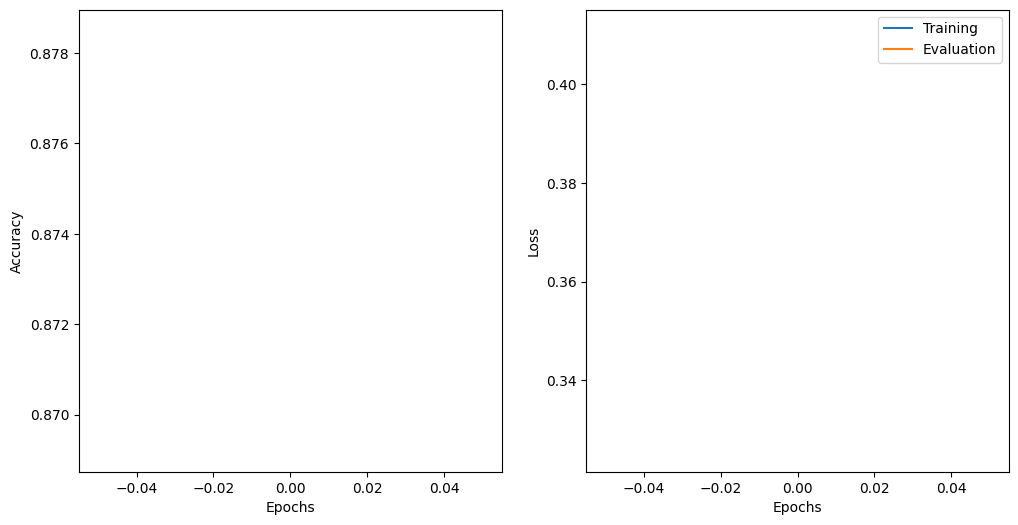

In [41]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)